In [21]:
import numpy as np

import torch
import torch.nn as nn
from torch.nn import MSELoss
from torch.optim import Adam
import torch.nn.functional as nnf
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import Dataset

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from torchinfo import summary

from utils.datasets import CIFAR_SR

from tqdm import tqdm

import matplotlib.pyplot as plt

from models.prediction.HVAE import HVAE

from utils.metrics import validation_scores

cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [22]:
path = "CIFAR_HVAE_divers5.pth"

x_dim = 32

scale_factor = 2
x_inp_dim  = int(x_dim / scale_factor)


# lr = 1e-3
epochs = 300
batch_size = 1024
batch_size_test = 128

train_dataset = CIFAR_SR(split="train", scale_factor=scale_factor)
test_dataset = CIFAR_SR(split="test", scale_factor=scale_factor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [23]:
in_channels = 3
channels = [32, 64, 128, 256]
latent_dims = [32, 32, 32]

model = HVAE(in_channels=in_channels, channels=channels, latent_dims=latent_dims, base_width=x_inp_dim).to(DEVICE)
summary(model, input_size=(1,in_channels, x_inp_dim, x_inp_dim))

Layer (type:depth-idx)                   Output Shape              Param #
HVAE                                     [1, 3, 32, 32]            --
├─HVAELREncoder: 1-1                     [1, 32]                   --
│    └─Conv2d: 2-1                       [1, 32, 16, 16]           128
│    └─Conv2d: 2-2                       [1, 64, 8, 8]             32,832
│    └─Conv2d: 2-3                       [1, 128, 4, 4]            131,200
│    └─Linear: 2-4                       [1, 32]                   65,568
│    └─Linear: 2-5                       [1, 32]                   65,568
│    └─Linear: 2-6                       [1, 32]                   131,104
│    └─Linear: 2-7                       [1, 32]                   131,104
│    └─Linear: 2-8                       [1, 32]                   262,176
│    └─Linear: 2-9                       [1, 32]                   262,176
├─Linear: 1-2                            [1, 32]                   1,056
├─Linear: 1-3                            [1,

In [7]:
def loss_function(x, x_hat, latents):
    reproduction_loss = MSELoss(reduction='sum')(x_hat, x)
    KLD = 0
    for mu, logvar in latents:
        KLD += -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (reproduction_loss + KLD) / x.size(0)

optimizer = Adam(model.parameters(), lr=1e-3)
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, threshold=0.0001)
scheduler = StepLR(optimizer, step_size=12, gamma=0.9)

In [16]:
scheduler = StepLR(optimizer, step_size=50, gamma=0.9)

In [5]:
model_loss = []

In [17]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        HR, LR = batch

        SR, latents = model(LR)
        # mean, log_var = latents[0]
        loss = loss_function(HR, SR, latents)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print("\tEpoch", epoch, "complete!", "\tAverage Loss: ", overall_loss)

    model_loss.append(overall_loss)
    scheduler.step()

print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss)
print("Finish!!")

Start training VAE...
	Epoch 0 complete! 	Average Loss:  2928.8723335266113
	Epoch 10 complete! 	Average Loss:  2927.775779724121
	Epoch 20 complete! 	Average Loss:  2927.3340225219727
	Epoch 30 complete! 	Average Loss:  2926.496078491211
	Epoch 40 complete! 	Average Loss:  2926.012908935547
	Epoch 50 complete! 	Average Loss:  2926.023765563965
	Epoch 60 complete! 	Average Loss:  2924.834934234619
	Epoch 70 complete! 	Average Loss:  2925.709186553955
	Epoch 80 complete! 	Average Loss:  2924.818218231201
	Epoch 90 complete! 	Average Loss:  2925.313388824463
	Epoch 100 complete! 	Average Loss:  2923.9454345703125
	Epoch 110 complete! 	Average Loss:  2923.522716522217
	Epoch 120 complete! 	Average Loss:  2923.5614433288574
	Epoch 130 complete! 	Average Loss:  2922.149227142334
	Epoch 140 complete! 	Average Loss:  2922.285427093506
	Epoch 150 complete! 	Average Loss:  2921.428726196289
	Epoch 160 complete! 	Average Loss:  2922.215030670166
	Epoch 170 complete! 	Average Loss:  2921.45955657

[]

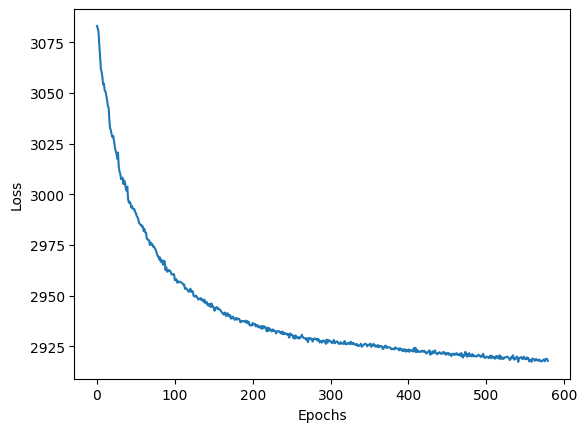

In [18]:
plt.plot(model_loss[20:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.yscale('log')
plt.plot()

In [26]:
HR, LR = test_dataset.get_samples(1000)
SR = model.sample(LR)

In [10]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

Diversity score (mean std across pixels): 0.04698
High diversity


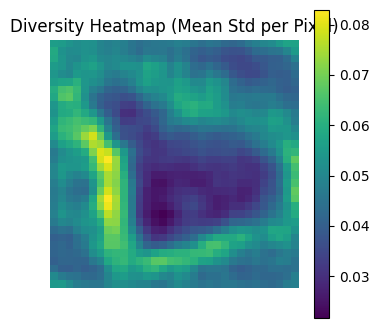

In [48]:
def visualize_diversity(model, lr_img, hr_img, num_samples=5):
    model.eval()
    generated_samples = []

    with torch.no_grad():
        # Prepare input
        lr_img = lr_img.unsqueeze(0)#.to(device)

        # Generate multiple predictions
        for _ in range(num_samples):
            recon_img = model.sample(lr_img)  # different latent each time
            generated_samples.append(recon_img.squeeze(0).cpu())  # (3, H, W)

    # Convert images for display
    lr_np = lr_img.cpu().squeeze().numpy().transpose(1, 2, 0)
    hr_np = hr_img.cpu().numpy().transpose(1, 2, 0)
    sample_nps = [sample.numpy().transpose(1, 2, 0) for sample in generated_samples]

    # ----- First Plot: Input + Samples + GT -----
    # fig1, axs1 = plt.subplots(1, num_samples + 2, figsize=(3 * (num_samples + 2), 3))
    # axs1[0].imshow(lr_np)
    # axs1[0].set_title("8x8 Input")
    # axs1[0].axis("off")

    # for i, sample_np in enumerate(sample_nps):
    #     axs1[i + 1].imshow(sample_np)
    #     axs1[i + 1].set_title(f"Sample {i+1}")
    #     axs1[i + 1].axis("off")

    # axs1[-1].imshow(hr_np)
    # axs1[-1].set_title("GT (32x32)")
    # axs1[-1].axis("off")

    # plt.tight_layout()
    # plt.show()

    # ----- Diversity Metric & Heatmap -----
    generated_stack = torch.stack(generated_samples)  # (num_samples, 3, H, W)
    std_per_pixel = torch.std(generated_stack, dim=0)  # (3, H, W)
    diversity_score = torch.mean(std_per_pixel).item()

    print(f"Diversity score (mean std across pixels): {diversity_score:.5f}")

    if diversity_score < 0.005:
        print("Very low diversity")
    elif diversity_score < 0.02:
        print("Moderate diversity")
    else:
        print("High diversity")

    diversity_map = torch.mean(std_per_pixel, dim=0).cpu().numpy()  # (H, W)

    # ----- Second Plot: Heatmap Only -----
    plt.figure(figsize=(4, 4))
    plt.imshow(diversity_map, cmap='viridis')
    plt.title("Diversity Heatmap (Mean Std per Pixel)")                                                           
    plt.colorbar()
    plt.axis("off")
    #plt.savefig(r"E:\GNN\gnn\datasets\models_neu\cifar32x32-4xscale\hvae-diversity-heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

    # ----- Third Plot: Combined Row with All -----
    # fig3, axs3 = plt.subplots(1, num_samples + 3, figsize=(3 * (num_samples + 3), 3))

    # axs3[0].imshow(lr_np)
    # axs3[0].set_title("8x8 Input")
    # axs3[0].axis("off")

    # for i, sample_np in enumerate(sample_nps):
    #     axs3[i + 1].imshow(sample_np)
    #     axs3[i + 1].set_title(f"Sample {i+1}")
    #     axs3[i + 1].axis("off")

    # axs3[-2].imshow(hr_np)
    # axs3[-2].set_title("GT (32x32)")
    # axs3[-2].axis("off")

    # axs3[-1].imshow(diversity_map, cmap='viridis')
    # axs3[-1].set_title("Diversity Heatmap")
    # axs3[-1].axis("off")

    # plt.tight_layout()
    # #plt.savefig(r"E:\GNN\gnn\datasets\models_neu\cifar32x32-4xscale\hvae-diversity-combined.png", dpi=300, bbox_inches='tight')
    # plt.show()


# Pick a random LR input
#hr_img, lr_img = val_dataset[random.randint(0, len(val_dataset)-1)]
visualize_diversity(model, LR[262], HR[262], num_samples=500)

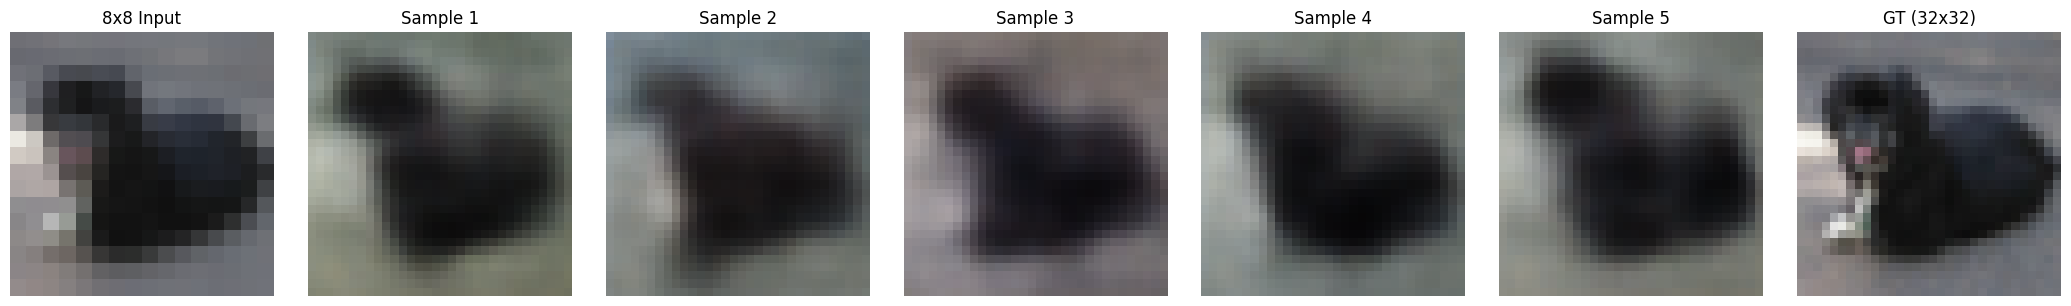

Diversity score (mean std across pixels): 0.03818
High diversity


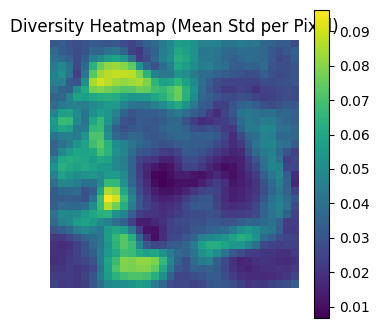

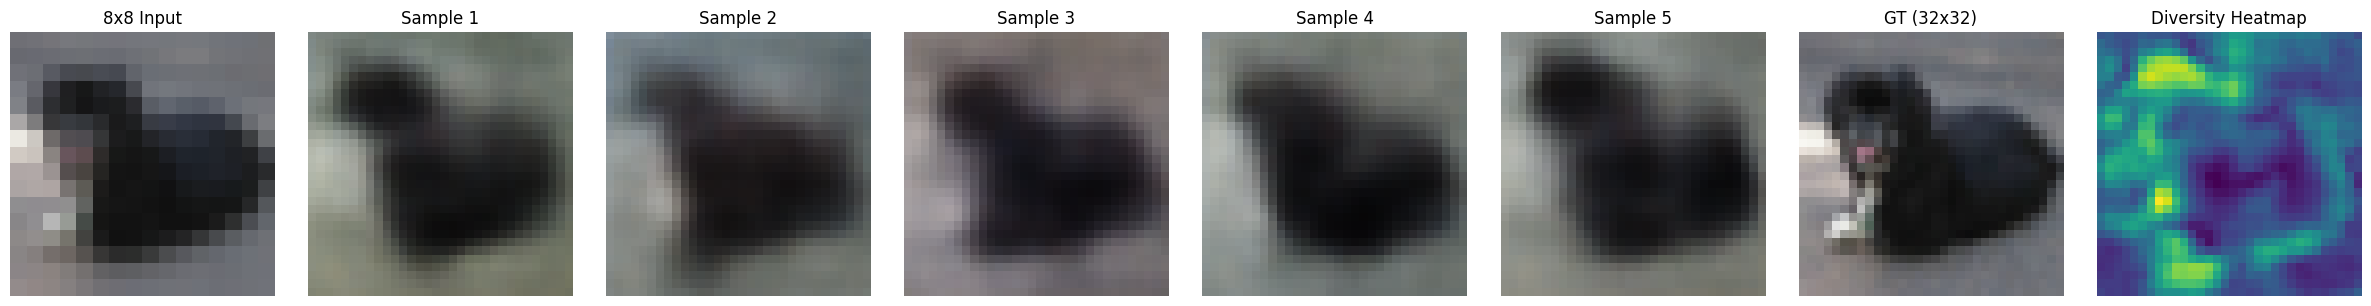

In [ ]:
def visualize_diversity(model, lr_img, hr_img, num_samples=5):
    model.eval()
    generated_samples = []

    with torch.no_grad():
        # Prepare input
        lr_img = lr_img.unsqueeze(0)#.to(device)

        # Generate multiple predictions
        for _ in range(num_samples):
            recon_img = model.sample(lr_img)  # different latent each time
            generated_samples.append(recon_img.squeeze(0).cpu())  # (3, H, W)

    # Convert images for display
    lr_np = lr_img.cpu().squeeze().numpy().transpose(1, 2, 0)
    hr_np = hr_img.cpu().numpy().transpose(1, 2, 0)
    sample_nps = [sample.numpy().transpose(1, 2, 0) for sample in generated_samples]

    # ----- First Plot: Input + Samples + GT -----
    fig1, axs1 = plt.subplots(1, num_samples + 2, figsize=(3 * (num_samples + 2), 3))
    axs1[0].imshow(lr_np)
    axs1[0].set_title("8x8 Input")
    axs1[0].axis("off")

    for i, sample_np in enumerate(sample_nps):
        axs1[i + 1].imshow(sample_np)
        axs1[i + 1].set_title(f"Sample {i+1}")
        axs1[i + 1].axis("off")

    axs1[-1].imshow(hr_np)
    axs1[-1].set_title("GT (32x32)")
    axs1[-1].axis("off")

    plt.tight_layout()
    plt.show()

    # ----- Diversity Metric & Heatmap -----
    generated_stack = torch.stack(generated_samples)  # (num_samples, 3, H, W)
    std_per_pixel = torch.std(generated_stack, dim=0)  # (3, H, W)
    diversity_score = torch.mean(std_per_pixel).item()

    print(f"Diversity score (mean std across pixels): {diversity_score:.5f}")

    if diversity_score < 0.005:
        print("Very low diversity")
    elif diversity_score < 0.02:
        print("Moderate diversity")
    else:
        print("High diversity")

    diversity_map = torch.mean(std_per_pixel, dim=0).cpu().numpy()  # (H, W)

    # ----- Second Plot: Heatmap Only -----
    plt.figure(figsize=(4, 4))
    plt.imshow(diversity_map, cmap='viridis')
    plt.title("Diversity Heatmap (Mean Std per Pixel)")                                                           
    plt.colorbar()
    plt.axis("off")
    #plt.savefig(r"E:\GNN\gnn\datasets\models_neu\cifar32x32-4xscale\hvae-diversity-heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

    # ----- Third Plot: Combined Row with All -----
    fig3, axs3 = plt.subplots(1, num_samples + 3, figsize=(3 * (num_samples + 3), 3))

    axs3[0].imshow(lr_np)
    axs3[0].set_title("8x8 Input")
    axs3[0].axis("off")

    for i, sample_np in enumerate(sample_nps):
        axs3[i + 1].imshow(sample_np)
        axs3[i + 1].set_title(f"Sample {i+1}")
        axs3[i + 1].axis("off")

    axs3[-2].imshow(hr_np)
    axs3[-2].set_title("GT (32x32)")
    axs3[-2].axis("off")

    axs3[-1].imshow(diversity_map, cmap='viridis')
    axs3[-1].set_title("Diversity Heatmap")
    axs3[-1].axis("off")

    plt.tight_layout()
    #plt.savefig(r"E:\GNN\gnn\datasets\models_neu\cifar32x32-4xscale\hvae-diversity-combined.png", dpi=300, bbox_inches='tight')
    plt.show()


# Pick a random LR input
#hr_img, lr_img = val_dataset[random.randint(0, len(val_dataset)-1)]
visualize_diversity(model, LR[262], HR[262], num_samples=5)

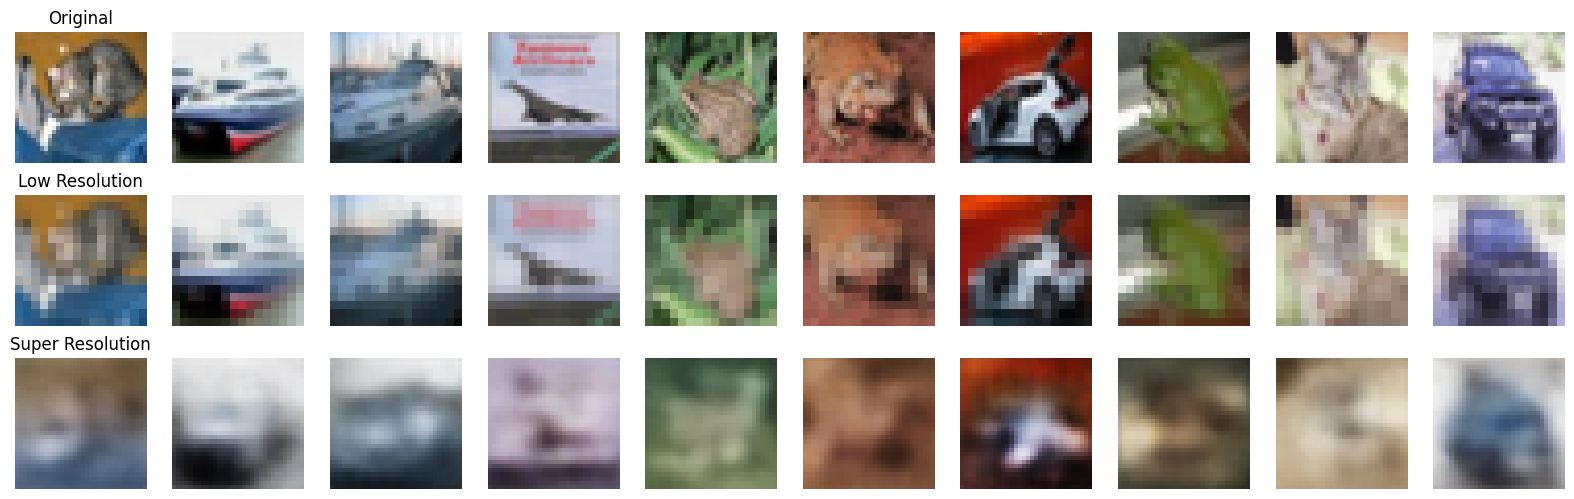

In [16]:
show_image(HR, LR, SR, 10)

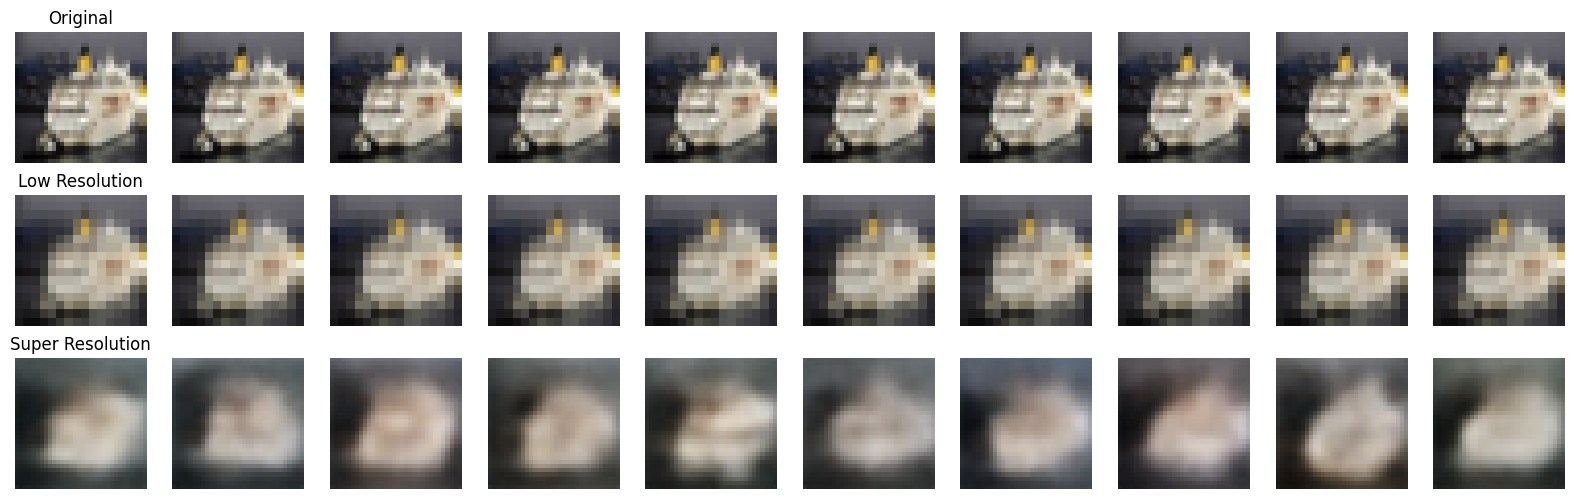

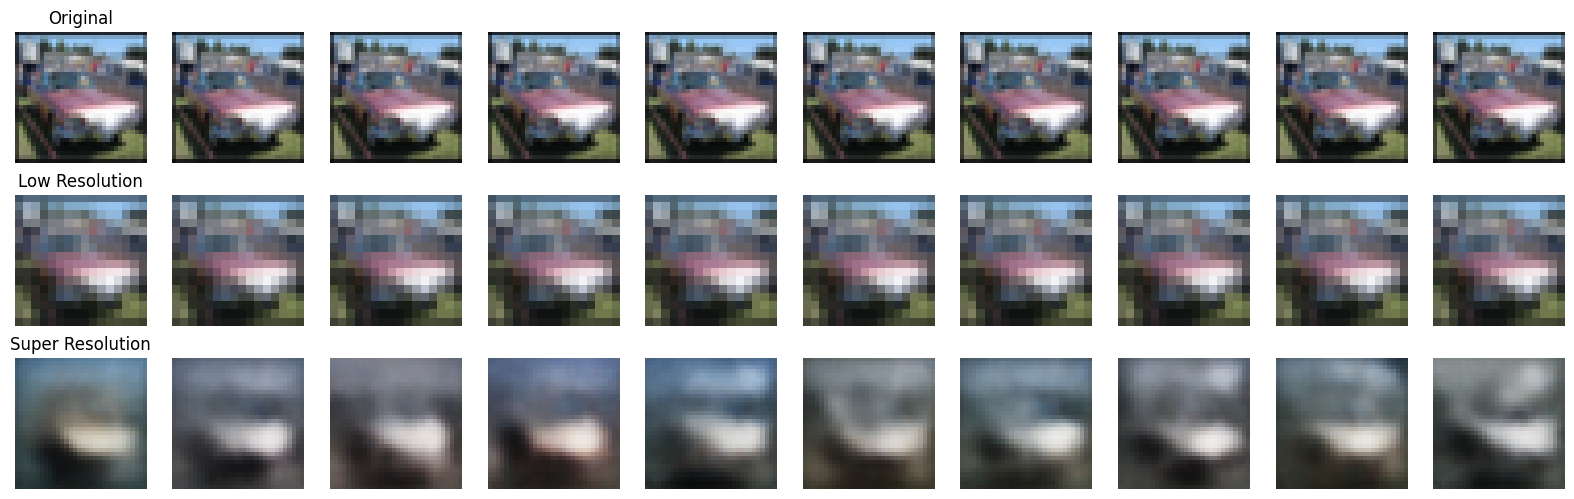

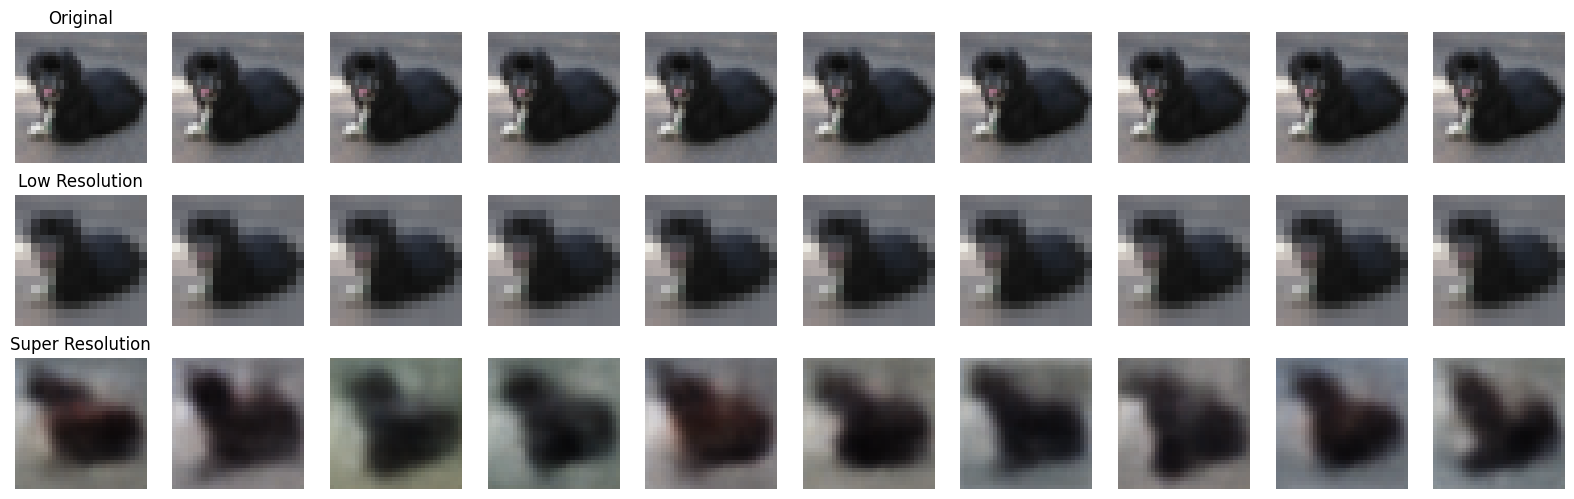

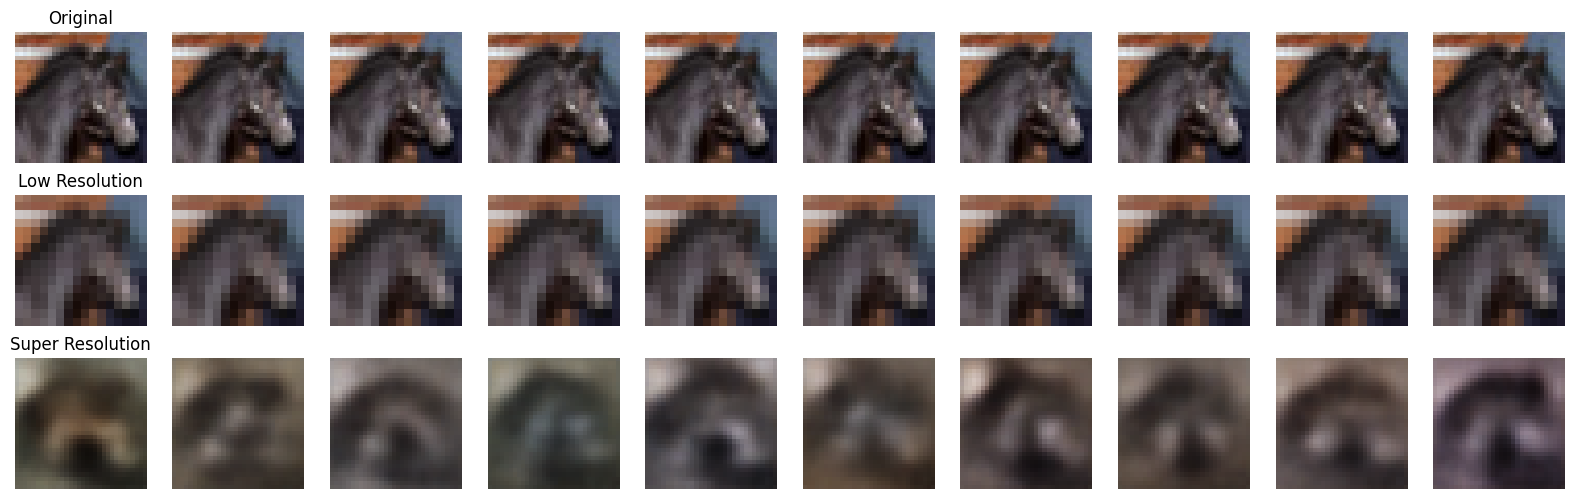

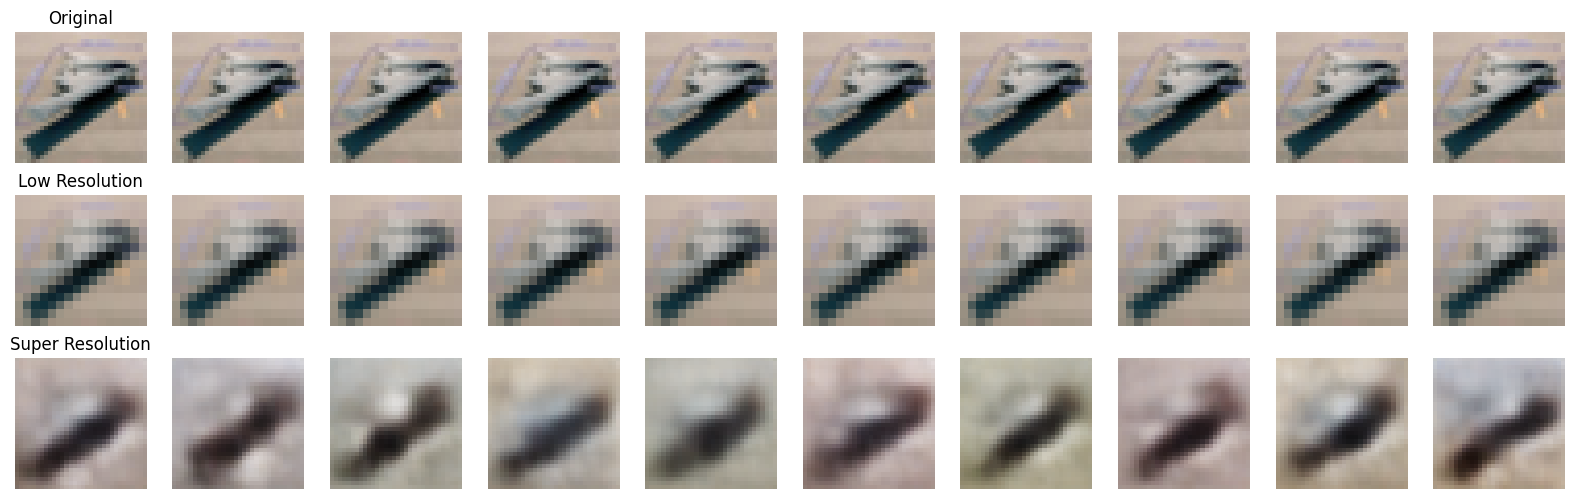

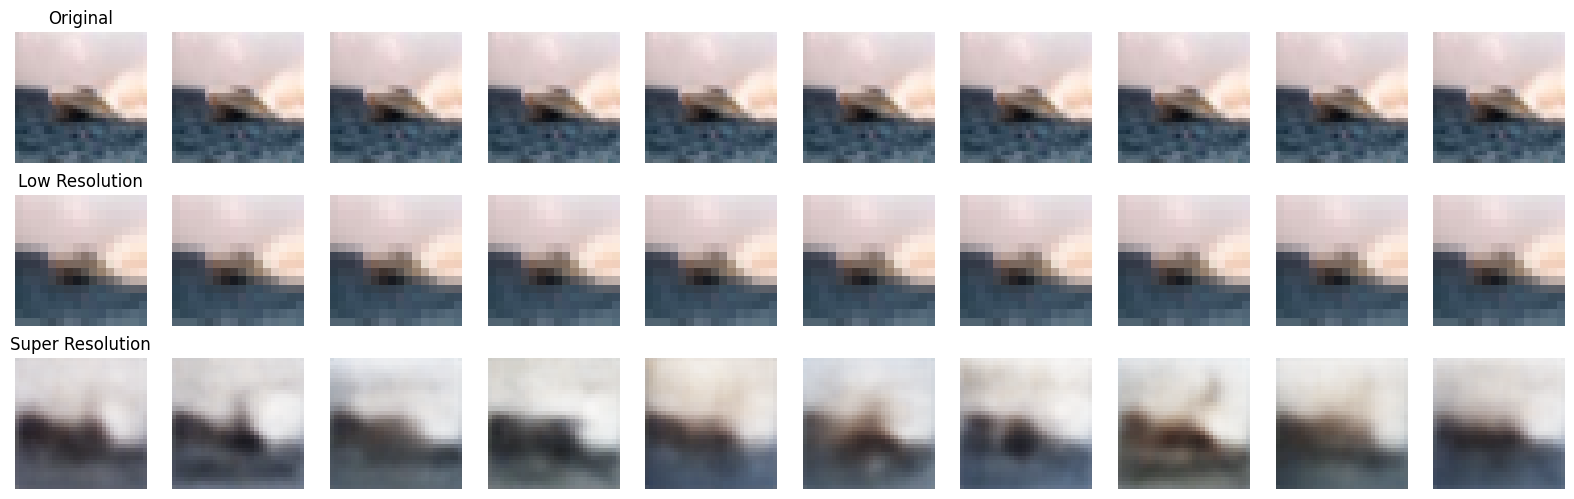

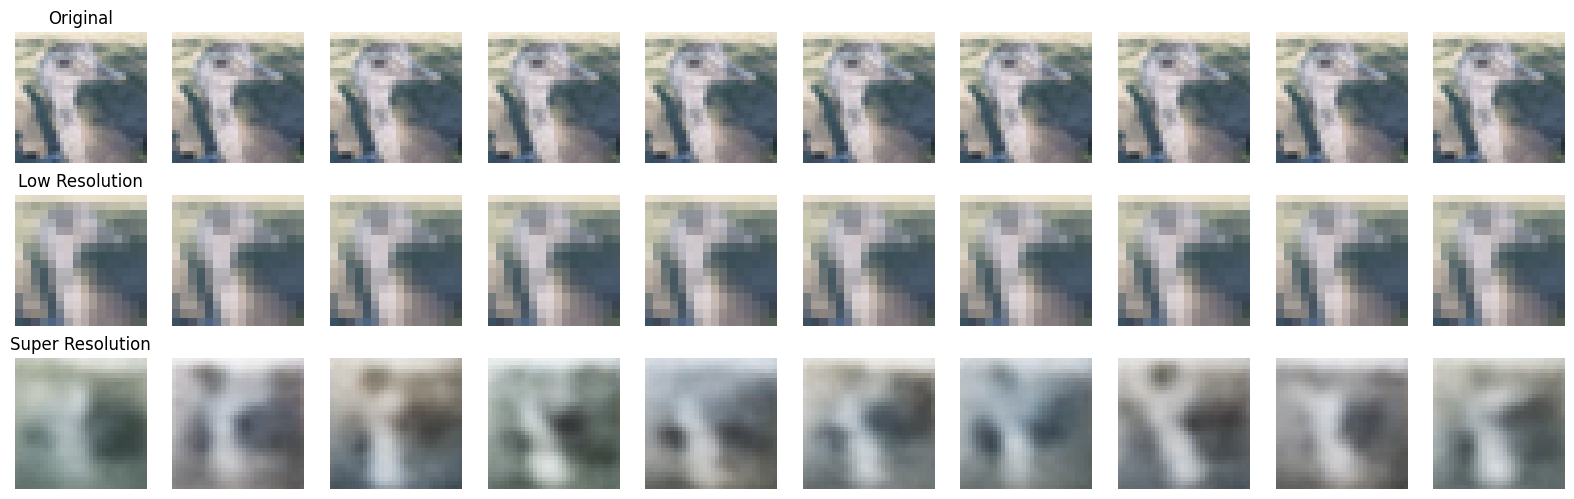

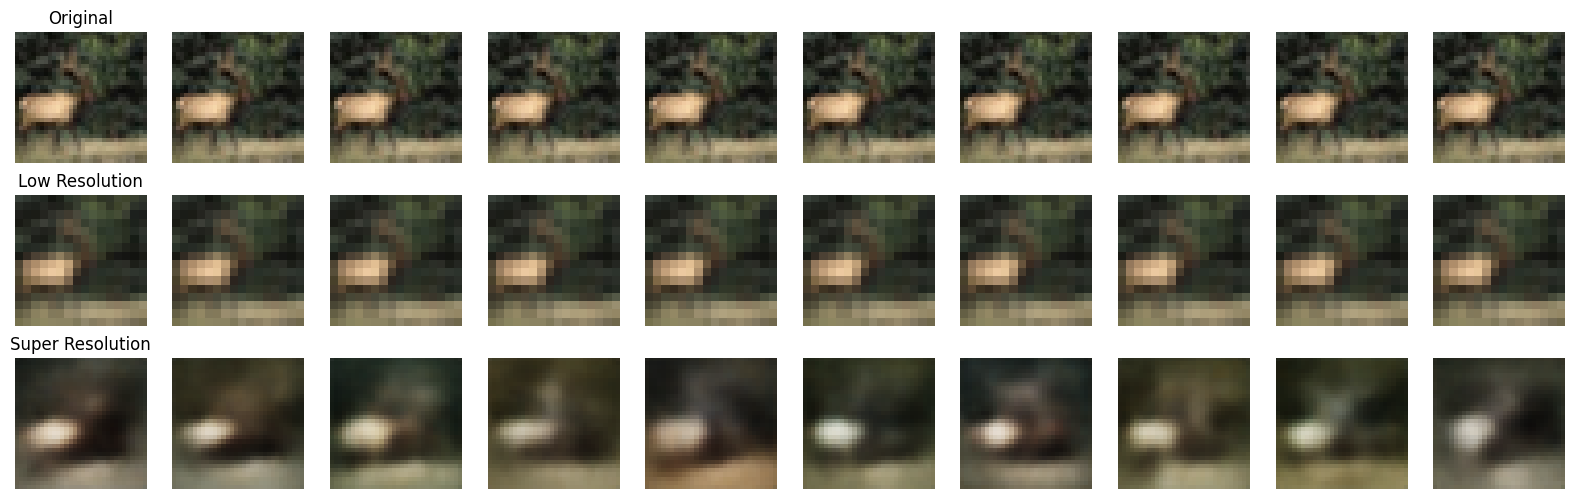

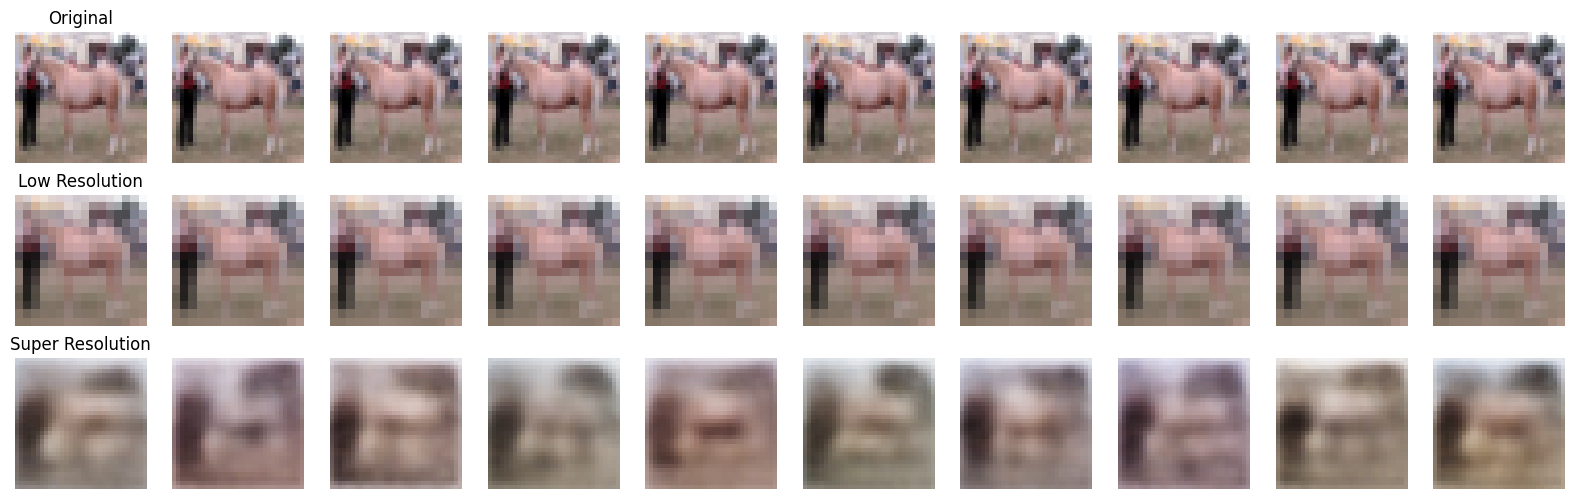

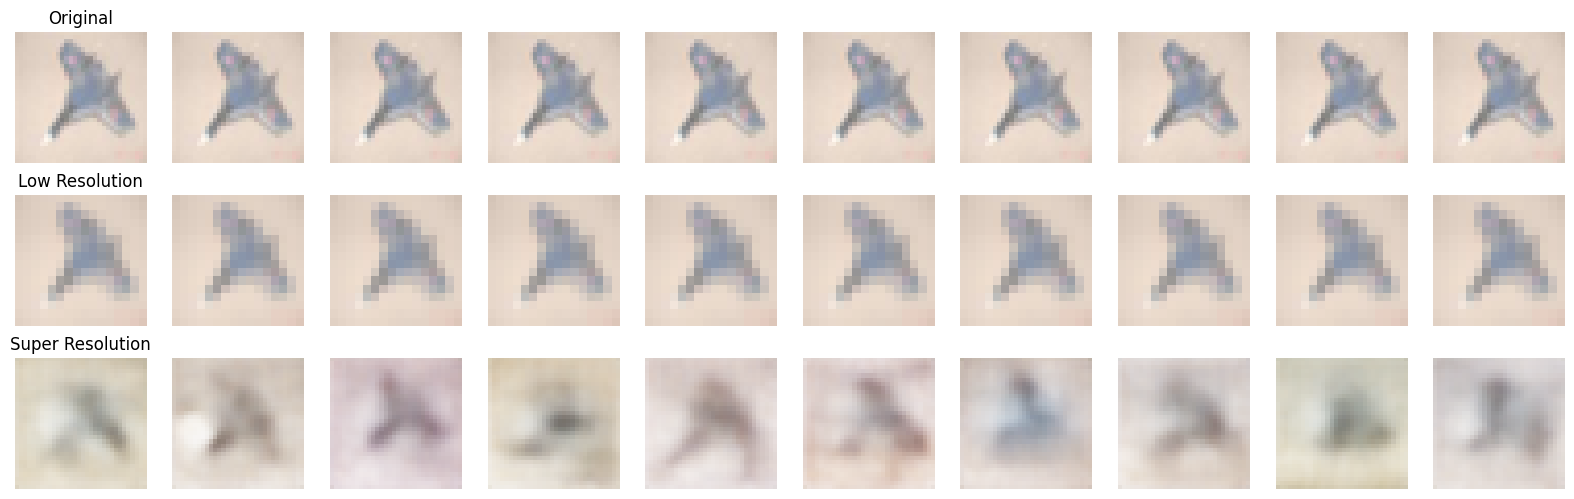

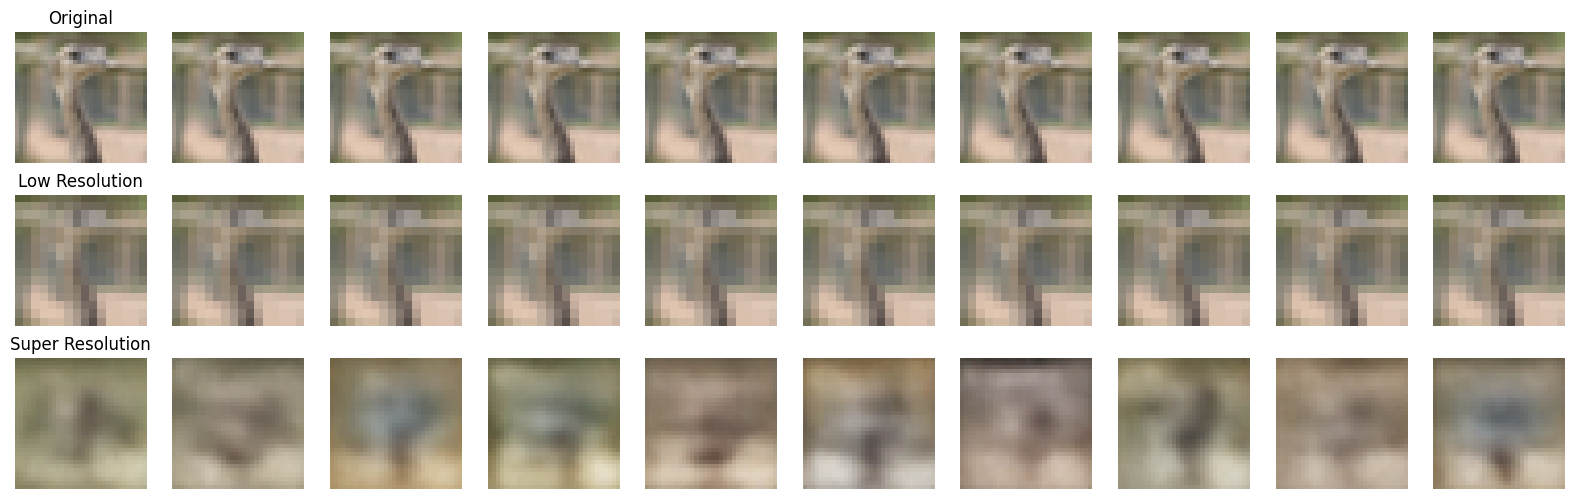

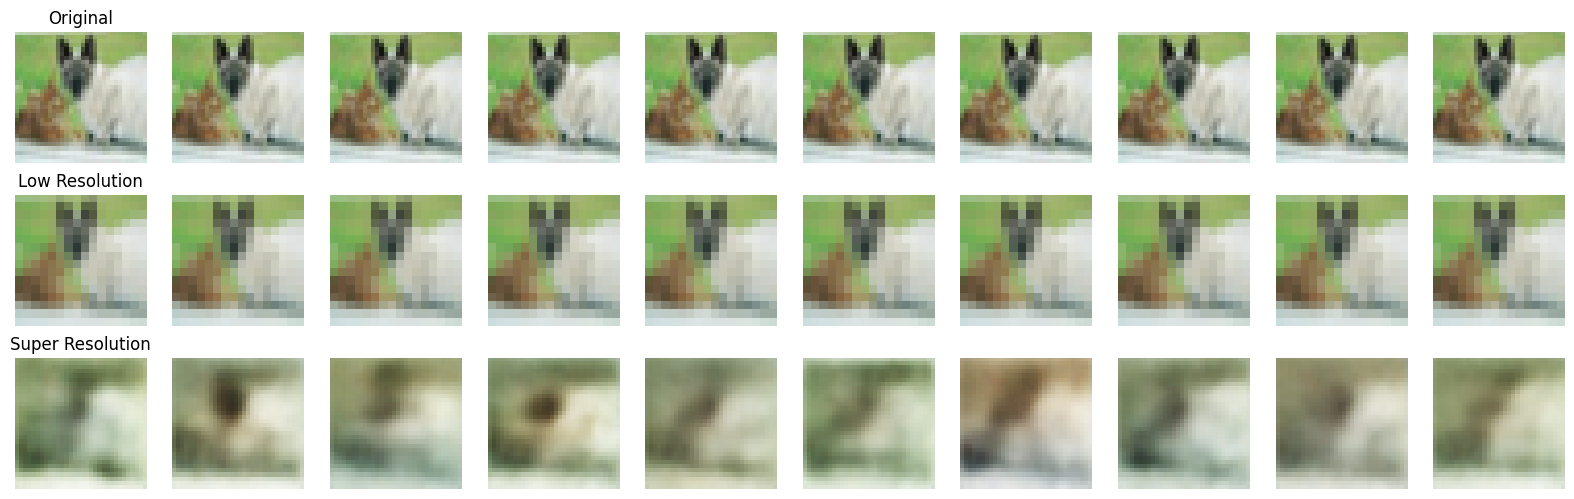

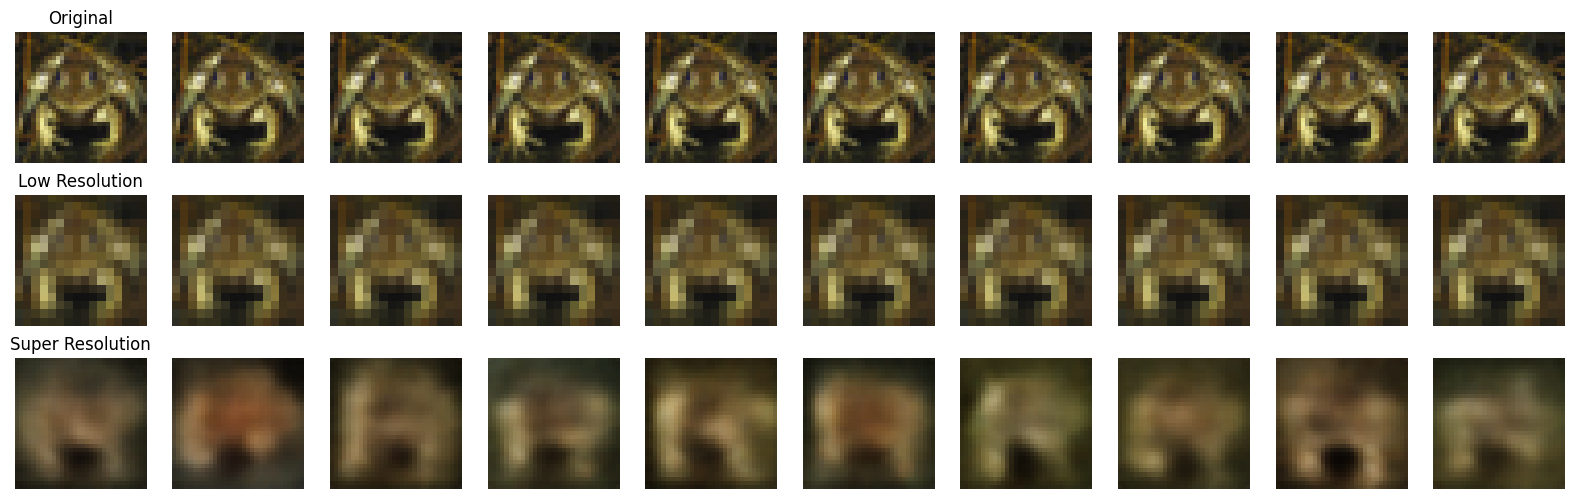

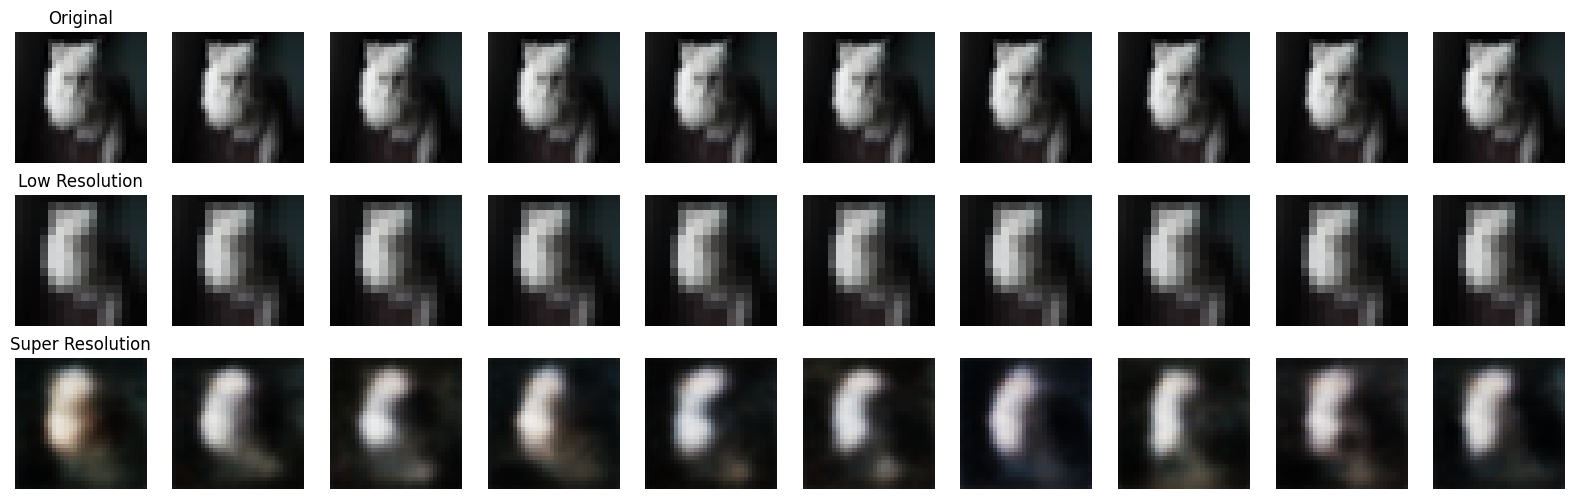

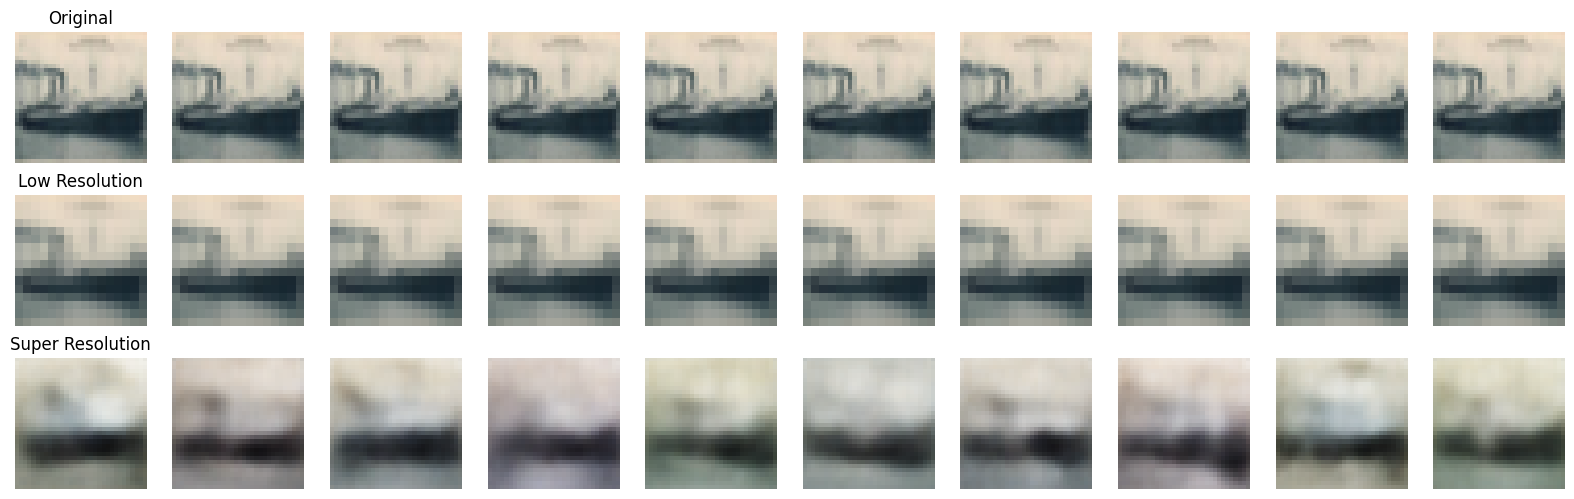

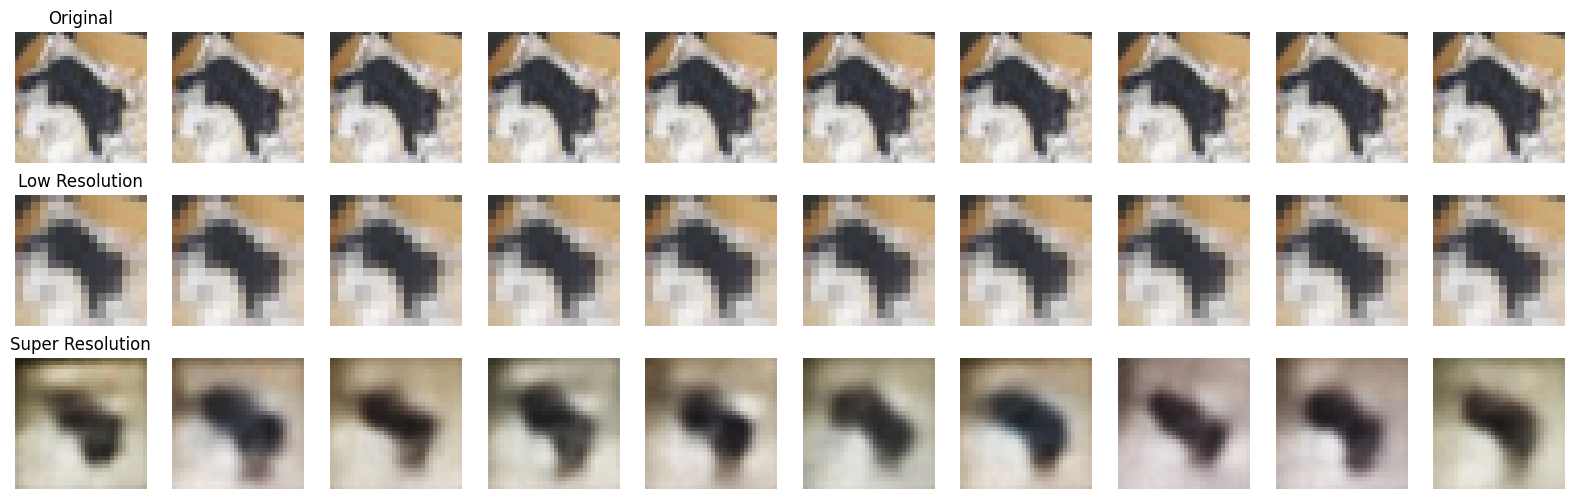

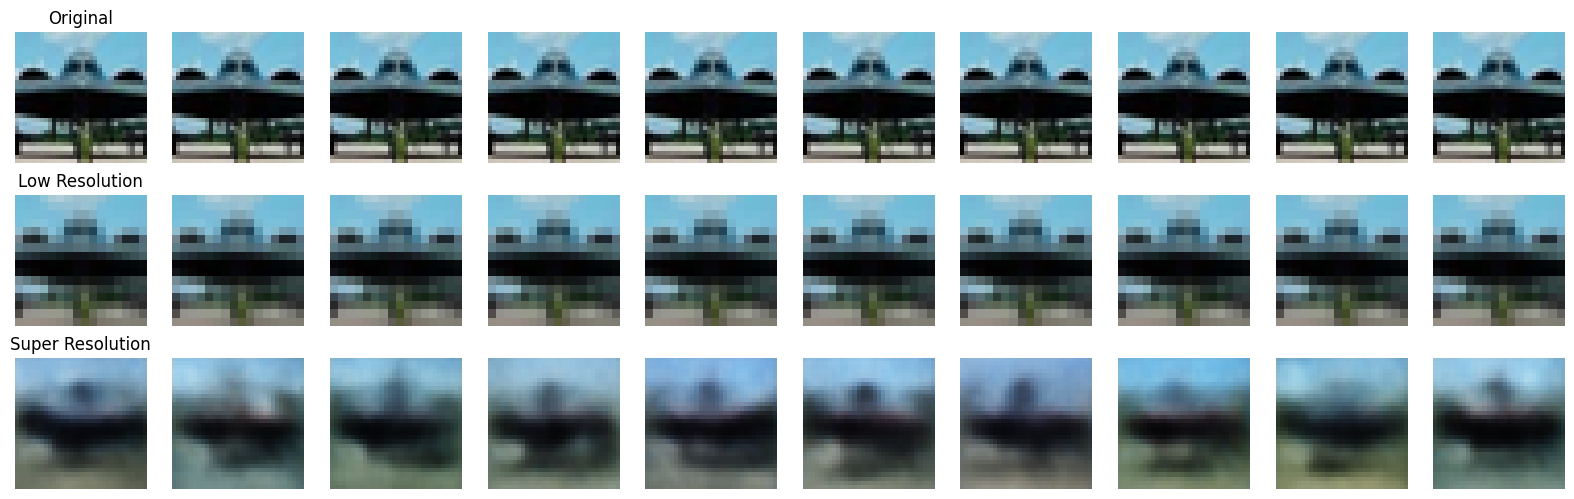

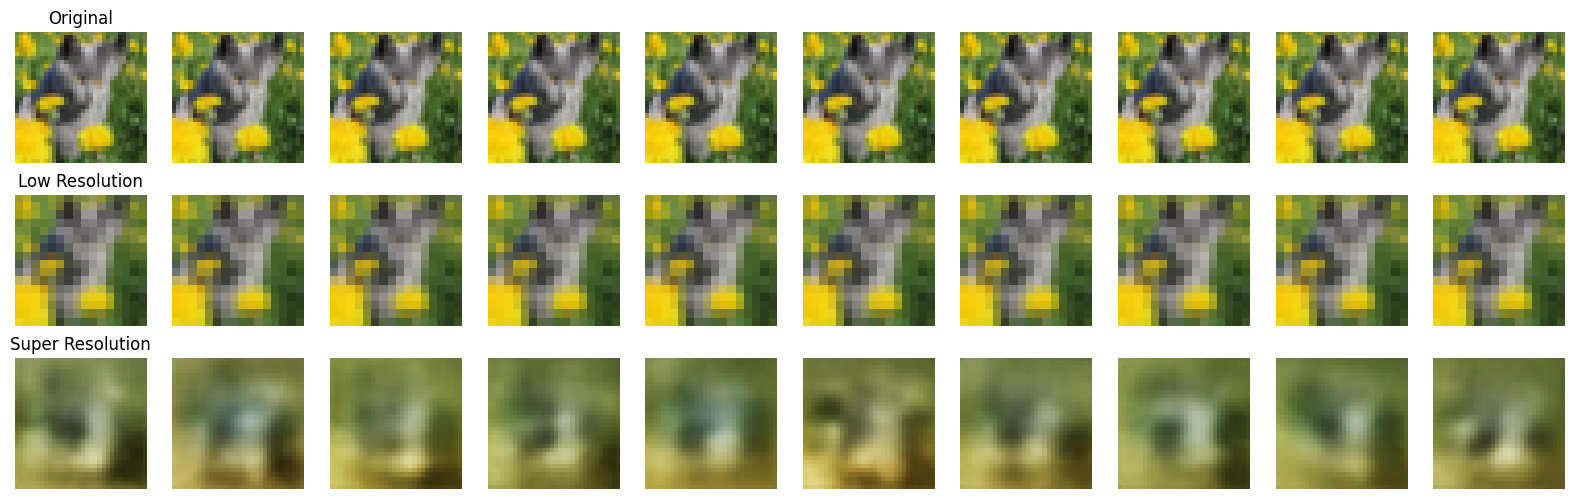

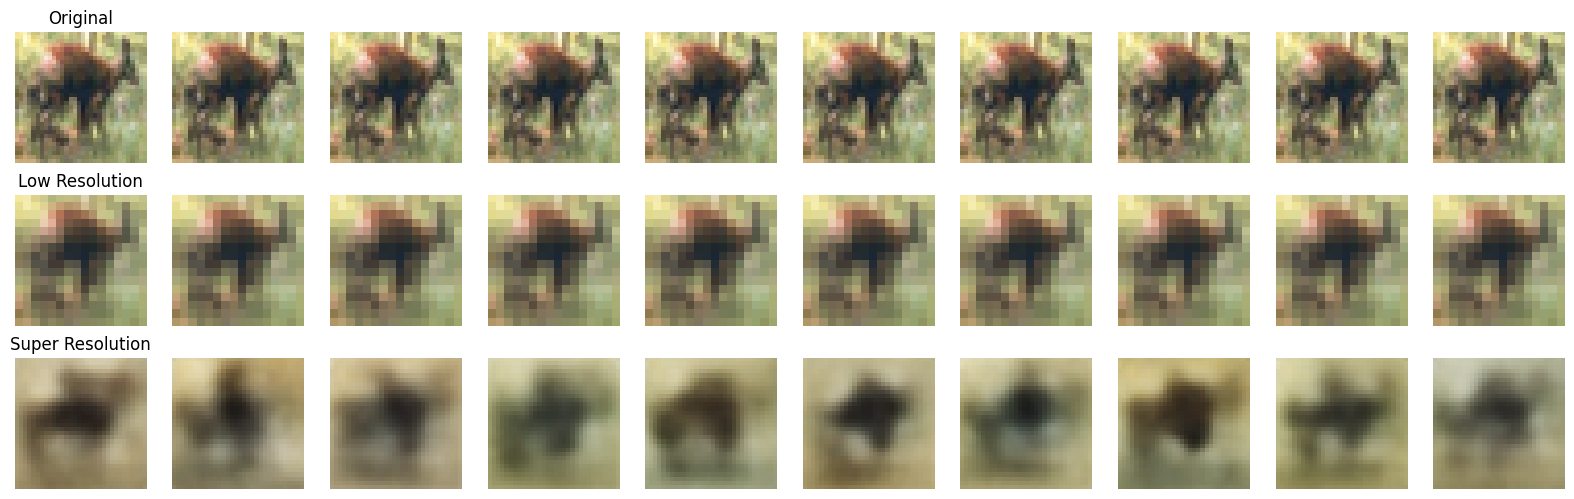

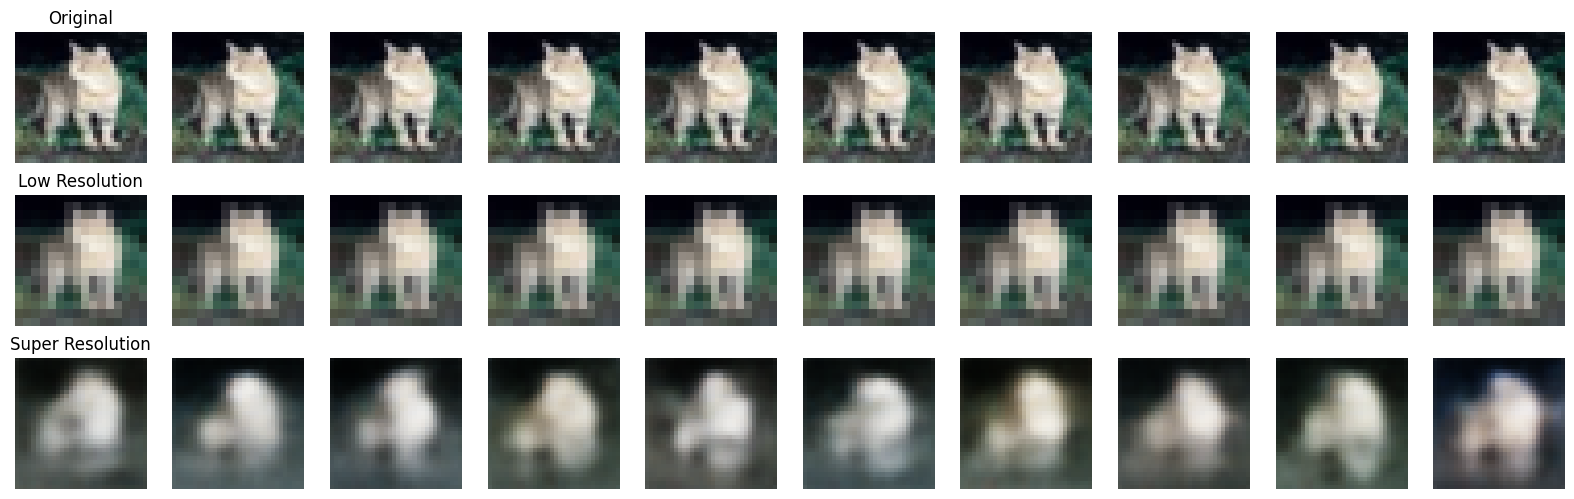

In [18]:
n_samp = 20
offset = 260

for i in range(offset, offset+n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

In [29]:
# save model
torch.save(model.state_dict(), path)

In [24]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [30]:
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("MSE:", mse_val)
print("Perceptual:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MSE: 0.012845934368669987
Perceptual: 6.128894805908203
PSNR: 19.273488998413086
SSIM: 0.4819113314151764
LPIPS: 0.5111742615699768
BRISQUE: 79.36421966552734
PSNR Consistency: 22.064157485961914
MSE Diversity: 0.004123112326851697
LPIPS Diversity: 0.19824369781417772
